In [1]:
# Data handling
import pandas as pd
import numpy as np
import os
import glob

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Train/Test Split
from sklearn.model_selection import train_test_split

# Evaluation Metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Misc
import warnings
warnings.filterwarnings("ignore")
from xgboost import XGBRegressor


In [2]:
# ======================================
# CELL 2 — LOAD ALL ATP CSV FILES
# ======================================

df = pd.concat(
    [pd.read_csv(f"data/atp_matches_{i}.csv") for i in range(2015, 2025)],
    ignore_index=True
)

df.head()


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2015-339,Brisbane,Hard,28,A,20150104,1,105357,NaN,WC,...,31.0,20.0,5.0,8.0,1.0,5.0,153.0,328.0,220.0,221.0
1,2015-339,Brisbane,Hard,28,A,20150104,2,103813,NaN,NaN,...,50.0,26.0,19.0,13.0,3.0,8.0,73.0,689.0,123.0,440.0
2,2015-339,Brisbane,Hard,28,A,20150104,3,105902,NaN,WC,...,37.0,22.0,5.0,8.0,10.0,15.0,125.0,430.0,21.0,1730.0
3,2015-339,Brisbane,Hard,28,A,20150104,4,104871,NaN,NaN,...,38.0,30.0,8.0,10.0,1.0,3.0,31.0,1195.0,72.0,691.0
4,2015-339,Brisbane,Hard,28,A,20150104,5,105373,NaN,NaN,...,62.0,40.0,19.0,15.0,4.0,8.0,34.0,1094.0,110.0,505.0


In [3]:
# ======================================
# CELL 3 — CLEAN & PREPROCESS
# ======================================

# Keep matches with duration
df = df[df["minutes"].notna() & (df["minutes"] > 0)]

# Remove RET/W.O./DEF matches if score exists
if "score" in df.columns:
    df = df[~df["score"].str.contains("W/O|RET|DEF", na=False)]

# Cast numeric columns
numeric_cols = [
    "winner_rank", "loser_rank", "winner_age", "loser_age",
    "winner_seed", "loser_seed", "winner_ht", "loser_ht",
    "rank_diff", "age_diff", "height_diff", "seed_diff",
    "minutes", "round"
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop rows missing essential values
df = df.dropna(subset=["winner_rank", "loser_rank", "winner_age", "loser_age", "minutes"])

print("Remaining rows:", len(df))


Remaining rows: 23960


In [4]:
# ======================================
# CELL 4 — FEATURE ENGINEERING (ranking-based)
# ======================================

# Ranking features
df["rank_diff"] = (df["winner_rank"] - df["loser_rank"]).abs()
df["avg_rank"] = (df["winner_rank"] + df["loser_rank"]) / 2

# Age features
df["age_diff"] = (df["winner_age"] - df["loser_age"]).abs()
df["avg_age"] = (df["winner_age"] + df["loser_age"]) / 2

# Height diff (if available)
df["height_diff"] = (df["winner_ht"] - df["loser_ht"]).abs()

# Seed diff
df["seed_diff"] = (df["winner_seed"] - df["loser_seed"]).abs()

# Same country
df["same_country"] = (df["winner_ioc"] == df["loser_ioc"]).astype(int)

# Round mapping
round_map = {"R128":1, "R64":2, "R32":3, "R16":4, "QF":5, "SF":6, "F":7}
df["round"] = df["round"].map(round_map).fillna(3)

df.head()


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,winner_rank_points,loser_rank,loser_rank_points,rank_diff,avg_rank,age_diff,avg_age,height_diff,seed_diff,same_country
0,2015-339,Brisbane,Hard,28,A,20150104,1,105357,NaN,WC,...,328.0,220.0,221.0,67.0,186.5,1.8,24.60,2.0,NaN,0
1,2015-339,Brisbane,Hard,28,A,20150104,2,103813,NaN,NaN,...,689.0,123.0,440.0,50.0,98.0,11.1,27.85,5.0,NaN,0
2,2015-339,Brisbane,Hard,28,A,20150104,3,105902,NaN,WC,...,430.0,21.0,1730.0,104.0,73.0,7.1,26.45,0.0,NaN,0
3,2015-339,Brisbane,Hard,28,A,20150104,4,104871,NaN,NaN,...,1195.0,72.0,691.0,41.0,51.5,0.4,27.60,8.0,NaN,0
4,2015-339,Brisbane,Hard,28,A,20150104,5,105373,NaN,NaN,...,1094.0,110.0,505.0,76.0,72.0,8.2,29.50,8.0,NaN,0


In [5]:
# ======================================
# CELL 5 — ONE-HOT ENCODING & FIX NaNs
# ======================================

# One-hot encode surface & tourney level
df = pd.get_dummies(df, columns=["surface"], prefix="surface")
df = pd.get_dummies(df, columns=["tourney_level"], prefix="tourney_level")

# Expected dummy columns
surface_cols = ["surface_Clay", "surface_Grass", "surface_Hard"]
tourney_cols = ["tourney_level_A", "tourney_level_G", "tourney_level_M"]

# Add missing columns with zeros
for col in surface_cols + tourney_cols:
    if col not in df.columns:
        df[col] = 0

# Final feature list (ranking-based only)
feature_cols = [
    "rank_diff", "avg_rank",
    "age_diff", "avg_age",
    "height_diff", "seed_diff", "same_country",
    "round"
] + surface_cols + tourney_cols

# Fill missing values
df[feature_cols] = df[feature_cols].fillna(0)

df[feature_cols].head()


,rank_diff,avg_rank,age_diff,avg_age,height_diff,seed_diff,same_country,round,surface_Clay,surface_Grass,surface_Hard,tourney_level_A,tourney_level_G,tourney_level_M
0,67.0,186.5,1.8,24.60,2.0,0.0,0,3.0,False,False,True,True,False,False
1,50.0,98.0,11.1,27.85,5.0,0.0,0,3.0,False,False,True,True,False,False
2,104.0,73.0,7.1,26.45,0.0,0.0,0,3.0,False,False,True,True,False,False
3,41.0,51.5,0.4,27.60,8.0,0.0,0,3.0,False,False,True,True,False,False
4,76.0,72.0,8.2,29.50,8.0,0.0,0,3.0,False,False,True,True,False,False


In [6]:
# ======================================
# CELL 6 — TRAIN/TEST SPLIT
# ======================================

df3 = df[df["best_of"] == 3].copy()
df5 = df[df["best_of"] == 5].copy()

X3 = df3[feature_cols]
y3 = df3["minutes"]

X5 = df5[feature_cols]
y5 = df5["minutes"]

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.25, random_state=42)
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.25, random_state=42)

len(X3_train), len(X5_train)


(14501, 3468)

In [7]:
# ======================================
# CELL 7 — TRAIN 4 MODELS + COMPARE
# ======================================

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(
        n_estimators=300, max_depth=12, min_samples_split=6, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=300, max_depth=3, learning_rate=0.05, random_state=42),
    "XGBoost": XGBRegressor(
        n_estimators=400, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, objective="reg:squarederror")
}

results = {}

for name, model in models.items():
    model_bo3 = model.fit(X3_train, y3_train)
    model_bo5 = model.fit(X5_train, y5_train)

    preds3 = model_bo3.predict(X3_test)
    preds5 = model_bo5.predict(X5_test)

    results[name] = {
        "BO3_R2": r2_score(y3_test, preds3),
        "BO3_RMSE": mean_squared_error(y3_test, preds3) ** 0.5,
        "BO5_R2": r2_score(y5_test, preds5),
        "BO5_RMSE": mean_squared_error(y5_test, preds5) ** 0.5,
    }

pd.DataFrame(results).T


,BO3_R2,BO3_RMSE,BO5_R2,BO5_RMSE
LinearRegression,-1.028008,45.618299,0.024339,48.080843
RandomForest,-2.316641,58.338263,0.042242,47.637649
GradientBoosting,-3.479787,67.800509,0.049103,47.466718
XGBoost,-3.517568,68.085811,-0.005610,48.813212


In [8]:
# ======================================
# CELL 8 — CHOOSE BEST MODEL (GradientBoosting)
# ======================================

gb3 = GradientBoostingRegressor(
    n_estimators=300, max_depth=3, learning_rate=0.05, random_state=42
).fit(X3_train, y3_train)

gb5 = GradientBoostingRegressor(
    n_estimators=300, max_depth=3, learning_rate=0.05, random_state=42
).fit(X5_train, y5_train)

print("Selected GradientBoosting models for BO3 + BO5")


Selected GradientBoosting models for BO3 + BO5


In [9]:
# ======================================
# CELL 9 — RANKING-BASED PREDICTION
# ======================================

def predict_expected_duration(
    rank1, rank2, age1, age2, surface, tourney_level, round_code, best_of):

    model = gb3 if best_of == 3 else gb5
    features = model.feature_names_in_

    row = pd.DataFrame({col: [0] for col in features})

    row.loc[0, "rank_diff"] = abs(rank1 - rank2)
    row.loc[0, "avg_rank"] = (rank1 + rank2) / 2

    row.loc[0, "age_diff"] = abs(age1 - age2)
    row.loc[0, "avg_age"] = (age1 + age2) / 2

    round_map = {"R128":1,"R64":2,"R32":3,"R16":4,"QF":5,"SF":6,"F":7}
    row.loc[0, "round"] = round_map.get(round_code, 3)

    for surf in ["Clay", "Grass", "Hard"]:
        col = f"surface_{surf}"
        if col in features:
            row.loc[0, col] = int(surface == surf)

    for lvl in ["A", "G", "M"]:
        col = f"tourney_level_{lvl}"
        if col in features:
            row.loc[0, col] = int(tourney_level == lvl)

    pred = model.predict(row)[0]

    pred = np.clip(pred, 45, 240)    # Reasonable range

    return pred


def duration_range(expected):
    spread = expected * 0.25
    return int(expected - spread), int(expected + spread)


def classify_duration(expected):
    if expected < 90:
        return "Short (<90 min)"
    elif expected < 150:
        return "Medium (90–150 min)"
    else:
        return "Long (>150 min)"


def predict_match_duration(
    rank1, rank2, age1, age2, surface, tourney_level, round_code, best_of):

    expected = predict_expected_duration(
        rank1, rank2, age1, age2, surface, tourney_level, round_code, best_of
    )

    low, high = duration_range(expected)
    category = classify_duration(expected)

    print(f"🎾 Expected duration: {expected:.1f} min")
    print(f"⏳ Likely range: {low}–{high} min")
    print(f"📊 Classification: {category}")

    return expected, (low, high), category


In [10]:
# ======================================
# CELL 10 — EXAMPLE PREDICTION
# ======================================

predict_match_duration(
    rank1=5,
    rank2=18,
    age1=27,
    age2=24,
    surface="Hard",
    tourney_level="A",
    round_code="QF",
    best_of=3
)


🎾 Expected duration: 106.1 min
⏳ Likely range: 79–132 min
📊 Classification: Medium (90–150 min)


(np.float64(106.10766376328088), (79, 132), 'Medium (90–150 min)')

In [11]:
# ======================================
# CELL 11 — CREATE DURATION CLASSES
# ======================================

def duration_class(minutes):
    if minutes < 90:
        return "Short"
    elif minutes < 150:
        return "Medium"
    else:
        return "Long"

df["duration_class"] = df["minutes"].apply(duration_class)

df["duration_class"].value_counts()


duration_class
Medium    11809
Short      7845
Long       4306
Name: count, dtype: int64

In [12]:
# ======================================
# CELL 12 — PREPARE CLASSIFICATION DATA
# ======================================

df3_class = df[df["best_of"] == 3].copy()
df5_class = df[df["best_of"] == 5].copy()

X3c = df3_class[feature_cols]
y3c = df3_class["duration_class"]

X5c = df5_class[feature_cols]
y5c = df5_class["duration_class"]

X3c_train, X3c_test, y3c_train, y3c_test = train_test_split(
    X3c, y3c, test_size=0.25, random_state=42
)

X5c_train, X5c_test, y5c_train, y5c_test = train_test_split(
    X5c, y5c, test_size=0.25, random_state=42
)


In [13]:
# ======================================
# CELL 13 — CLASSIFIER MODELS
# ======================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

clf3 = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_split=6,
    random_state=42
).fit(X3c_train, y3c_train)

clf5 = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_split=6,
    random_state=42
).fit(X5c_train, y5c_train)

# Predictions
preds_3 = clf3.predict(X3c_test)
preds_5 = clf5.predict(X5c_test)

acc3 = accuracy_score(y3c_test, preds_3)
acc5 = accuracy_score(y5c_test, preds_5)

print("BO3 Classification Accuracy:", round(acc3, 3))
print("BO5 Classification Accuracy:", round(acc5, 3))


BO3 Classification Accuracy: 0.498
BO5 Classification Accuracy: 0.557


In [14]:
# ======================================
# CELL 14 — CONFUSION MATRIX
# ======================================

print("=== BO3 Confusion Matrix ===")
print(pd.DataFrame(confusion_matrix(y3c_test, preds_3),
                   index=["Short","Medium","Long"],
                   columns=["Short","Medium","Long"]))

print("\n=== BO5 Confusion Matrix ===")
print(pd.DataFrame(confusion_matrix(y5c_test, preds_5),
                   index=["Short","Medium","Long"],
                   columns=["Short","Medium","Long"]))


=== BO3 Confusion Matrix ===
        Short  Medium  Long
Short       0     478    22
Medium      0    2274   156
Long        0    1770   134

=== BO5 Confusion Matrix ===
        Short  Medium  Long
Short     409     155     0
Medium    320     235     1
Long       19      17     1


In [15]:
# ======================================
# CELL 15 — MASTER PREDICTION FUNCTION
# ======================================

def predict_match(
    rank1, rank2, age1, age2, surface, tourney_level, round_code, best_of):

    # Pick classifier + regressor
    clf = clf3 if best_of == 3 else clf5
    reg = gb3 if best_of == 3 else gb5

    # Create feature row
    features = reg.feature_names_in_
    row = pd.DataFrame({col: [0] for col in features})

    # Ranking
    row.loc[0, "rank_diff"] = abs(rank1 - rank2)
    row.loc[0, "avg_rank"] = (rank1 + rank2) / 2

    # Age
    row.loc[0, "age_diff"] = abs(age1 - age2)
    row.loc[0, "avg_age"]  = (age1 + age2) / 2

    # Round
    round_map = {"R128":1, "R64":2, "R32":3, "R16":4, "QF":5, "SF":6, "F":7}
    row.loc[0, "round"] = round_map.get(round_code, 3)

    # Surface
    for surf in ["Clay","Grass","Hard"]:
        col = f"surface_{surf}"
        if col in features:
            row.loc[0, col] = int(surface == surf)

    # Tourney Level
    for lvl in ["A","G","M"]:
        col = f"tourney_level_{lvl}"
        if col in features:
            row.loc[0, col] = int(tourney_level == lvl)

    # Run regression (expected minutes)
    expected = float(reg.predict(row)[0])
    expected = float(np.clip(expected, 45, 240))

    # Run classification
    class_pred = clf.predict(row)[0]
    class_probs = clf.predict_proba(row)[0]

    # Convert to nice dict
    prob_dict = dict(zip(clf.classes_, np.round(class_probs, 3)))

    # Duration range
    spread = expected * 0.25
    low, high = expected - spread, expected + spread

    print(f"🎾 Expected duration: {expected:.1f} minutes")
    print(f"📊 Duration class: {class_pred}")
    print(f"🔢 Probabilities: {prob_dict}")
    print(f"⏳ Likely range: {int(low)}–{int(high)} minutes")

    return expected, class_pred, prob_dict, (low, high)


In [16]:
# ======================================
# CELL 16 — EXAMPLE PREDICTION
# ======================================

predict_match(
    rank1=5,
    rank2=18,
    age1=27,
    age2=24,
    surface="Hard",
    tourney_level="A",
    round_code="QF",
    best_of=3
)


🎾 Expected duration: 106.1 minutes
📊 Duration class: Medium
🔢 Probabilities: {'Long': np.float64(0.113), 'Medium': np.float64(0.504), 'Short': np.float64(0.383)}
⏳ Likely range: 79–132 minutes


(106.10766376328088,
 'Medium',
 {'Long': np.float64(0.113),
  'Medium': np.float64(0.504),
  'Short': np.float64(0.383)},
 (79.58074782246067, 132.6345797041011))

<Axes: >

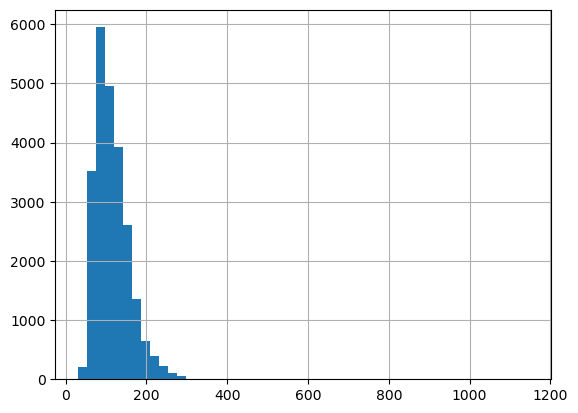

In [17]:
df["minutes"].hist(bins=50)

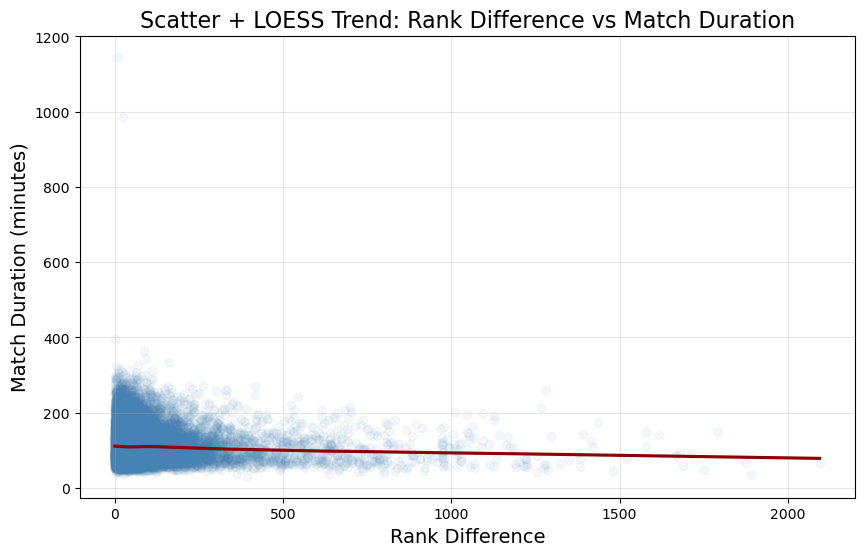


Correlation between rank_diff and minutes: -0.0553



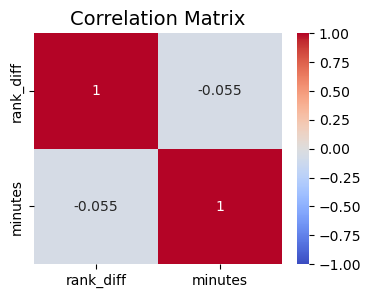

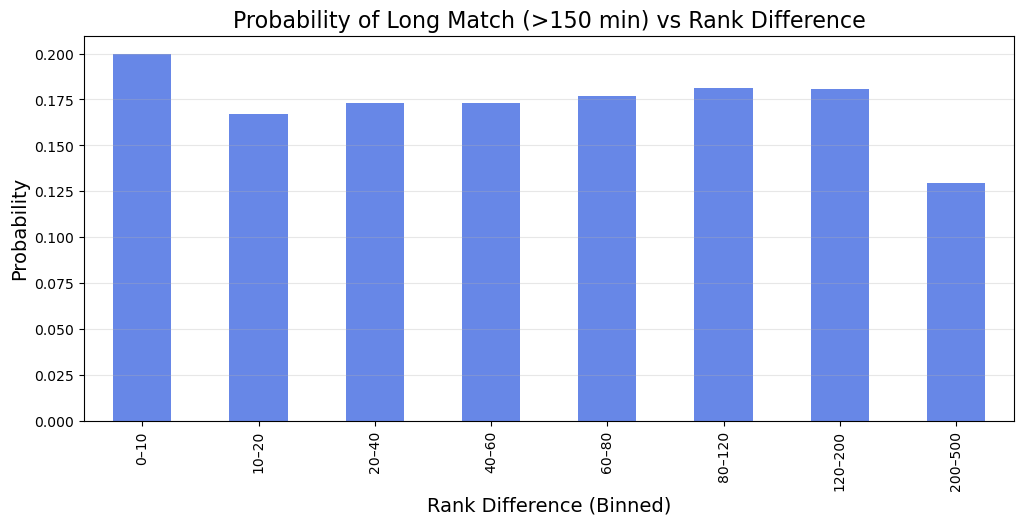

In [18]:
# ======================================================
# 3 MEANINGFUL PLOTS FOR RANK vs MATCH DURATION
# ======================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ------------------------------------------------------
# 1) Scatter Plot + LOESS Smoothing
# ------------------------------------------------------
plt.figure(figsize=(10,6))
sns.regplot(
    x="rank_diff",
    y="minutes",
    data=df,
    scatter_kws={"alpha":0.05, "color":"steelblue"},
    line_kws={"color":"darkred"},
    lowess=True
)
plt.title("Scatter + LOESS Trend: Rank Difference vs Match Duration", fontsize=16)
plt.xlabel("Rank Difference", fontsize=14)
plt.ylabel("Match Duration (minutes)", fontsize=14)
plt.grid(alpha=0.3)
plt.show()


# ------------------------------------------------------
# 2) Correlation value
# ------------------------------------------------------
corr_value = df[["rank_diff", "minutes"]].corr().iloc[0,1]
print(f"\nCorrelation between rank_diff and minutes: {corr_value:.4f}\n")

# Heatmap visualization
plt.figure(figsize=(4,3))
sns.heatmap(df[["rank_diff", "minutes"]].corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix", fontsize=14)
plt.show()


# ------------------------------------------------------
# 3) Probability of a Long Match (>150 minutes)
# ------------------------------------------------------

# Create duration class for long matches
df["is_long"] = (df["minutes"] > 150).astype(int)

# Rank difference bins
df["rank_diff_bin"] = pd.cut(
    df["rank_diff"],
    bins=[0,10,20,40,60,80,120,200,500],
    labels=["0–10","10–20","20–40","40–60","60–80","80–120","120–200","200–500"]
)

long_probs = df.groupby("rank_diff_bin")["is_long"].mean()

plt.figure(figsize=(12,5))
long_probs.plot(kind="bar", color="royalblue", alpha=0.8)
plt.title("Probability of Long Match (>150 min) vs Rank Difference", fontsize=16)
plt.ylabel("Probability", fontsize=14)
plt.xlabel("Rank Difference (Binned)", fontsize=14)
plt.grid(axis="y", alpha=0.3)
plt.show()
